# Random Forest

This script is to perform Random Forest for the processed embedding array.

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter


## Define Function

In [3]:
def define_data(X_embedding, y_label_list, min_group_size=1, remove_unclassified = True):
    y_label = np.array(y_label_list)
    # Kick out the unexpected groups     
    lbs = Counter(y_label)
    lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
    sel_index=[]
    for i,v in enumerate(list(lbs.values())):
        if v >= min_group_size:
            sel_index.append(i)
    select_lbs = [list(lbs.keys())[i] for i in sel_index]   
    if remove_unclassified == True:
        if 'Unclassified' in select_lbs:
            select_lbs.remove('Unclassified')           
    print(str(len(select_lbs))+' groups were selected.')    
    # Connect the selected groups to embeddings
    select_index = []
    for i in select_lbs:
        temp_index, = np.where(y_label==i)
        #print(temp_index)
        select_index += list(temp_index)
    select_index.sort()
    #print(select_index)
    y_label_2 = np.array(y_label[select_index])
    print(y_label_2.shape)
    X_embedding_2=X_embedding[select_index,:]
    print(X_embedding_2.shape)
    return X_embedding_2, y_label_2


def perform_randomforest(X_embedding, y_label, testing_size = 0.25, stratification=True):
    # Split the dataset into the Training set and Test set
    if stratification == True:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0, stratify=y_label)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0)
    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    ## Train Model
    t0=time.process_time()
    # Instantiate model with 10 decision trees
    rf = RandomForestClassifier(n_estimators = 160, random_state = 0)
    # Train the model on training data
    rf.fit(X_train, y_train)
    t1=time.process_time()-t0
    y_pred = rf.predict(X_test)
    print('Processing time: %.3f' % t1)

    ## Evaluate the model
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    conf_mat = confusion_matrix(y_test,y_pred)
    labels =list(np.unique(np.array(list(y_test)+list(y_pred))))
    return conf_mat,y_test,y_train,y_pred,labels



def plot_confusion_matrix(confusion_mat, labels, save_path, heatmap=False):    
    # Plot Confusion matrix  # Ignore: this plot is too large to plot.
    if len(labels) >= 10:
        a = len(labels)//5+5;
    else:
        a = 5
    
    df_cm = pd.DataFrame(confusion_mat, columns=np.unique(labels), index = np.unique(labels))
    df_cm.to_pickle(save_path+'.pkl')
    if heatmap==True:
        plt.figure(figsize = (a,a*4//5))
        ax= plt.subplot()
        df_cm.index.name = 'Actual labels'
        df_cm.columns.name = 'Predicted labels'
        sns.set(font_scale=1.8)
        sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})
        plt.savefig(save_path+'.svg',dpi=300,bbox_inches='tight')
    return df_cm
  
    
def calculate_accuracy_per_label(label, conf_matrix, y_train, save_path):
    accuracy = []
    group_size_pred=[]
    group_size_test=[]
    group_size_train=[]
    group_size = []
    predict_vs_test_size=[]
    group_size_train_dict = {k:list(y_train).count(k) for k in label}
    for i in range(len(label)):
        if label[i] != 'Unclassified':
            true_result = conf_matrix[i,i]
            all_result_pred = np.sum(conf_matrix,axis=0)[i]
            group_size_pred.append(all_result_pred)
            all_result_test = np.sum(conf_matrix,axis=1)[i]
            #print(all_result_pred, all_result_test)
            group_size_test.append(all_result_test)
            group_size_train.append(group_size_train_dict[label[i]])
            group_size.append(all_result_test+group_size_train_dict[label[i]])

            if all_result_pred == 0:
                accuracy.append(0)
            else:
                accuracy.append(true_result/all_result_pred)

            if all_result_test == 0:
                predict_vs_test_size.append(all_result_pred+1)
            else:
                predict_vs_test_size.append(all_result_pred/all_result_test)
    if 'Unclassified' in label:
        print('Removing Unclassified groups')
        label.remove('Unclassified')
    accuracy_dict = {'labels':label, 'accuracy':accuracy,'predict_vs_test_size': predict_vs_test_size,'group_size': group_size,
                     'group_size_pred':group_size_pred, 'group_size_test':group_size_test, 'group_size_train':group_size_train}
    with open(save_path, 'wb') as f:
        pickle.dump(accuracy_dict, f)
    return accuracy_dict


def scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x, x_label, datatype, save_dir):
    x= accuracy_dict[x_label]
    y= accuracy_dict['accuracy']
    plt.rcParams.update({'figure.figsize':(10,7)})
    plt.scatter(x, y)

    plt.title('Accuracy of predicted results vs. %s in %s' % (x_label, datatype))
    plt.xlabel(x_label)
    plt.ylabel('Accuracy per group')
    for i,txt in enumerate(accuracy_dict['labels']):
        if x[i] >= show_annot_min_x:
            plt.annotate(txt,(x[i],y[i]), fontsize=10)
    plt.savefig(save_dir,dpi = 100, bbox_inches='tight')
    plt.show()
    

    

## Loading array from csv file

In [4]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)

(16360, 300)


### Class in ClassyFire

(16360,)
183 groups were selected.
(15034,)
(15034, 300)
Processing time: 106.603
Accuracy: 0.350


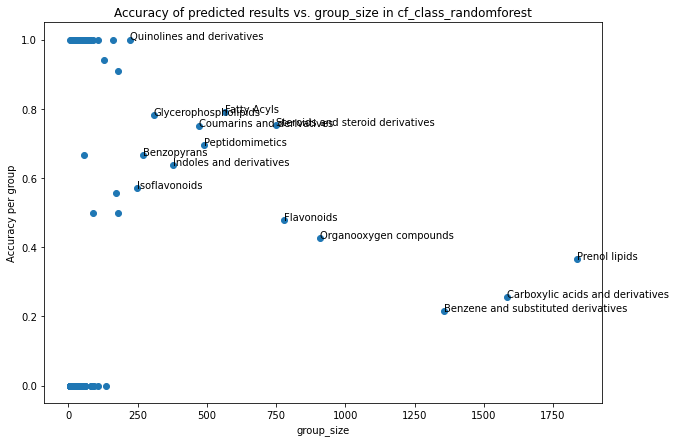

In [5]:
data_type='cf_class_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Superclass in ClassyFire

(16360,)
17 groups were selected.
(15261,)
(15261, 300)
Processing time: 26.408
Accuracy: 0.523


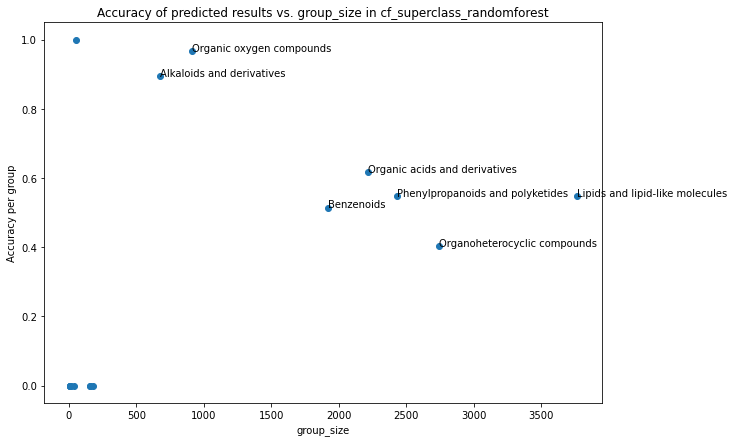

In [6]:
data_type='cf_superclass_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_superclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Subclass in ClassyFire

(16360,)
288 groups were selected.
(12552,)
(12552, 300)
Processing time: 145.933
Accuracy: 0.297


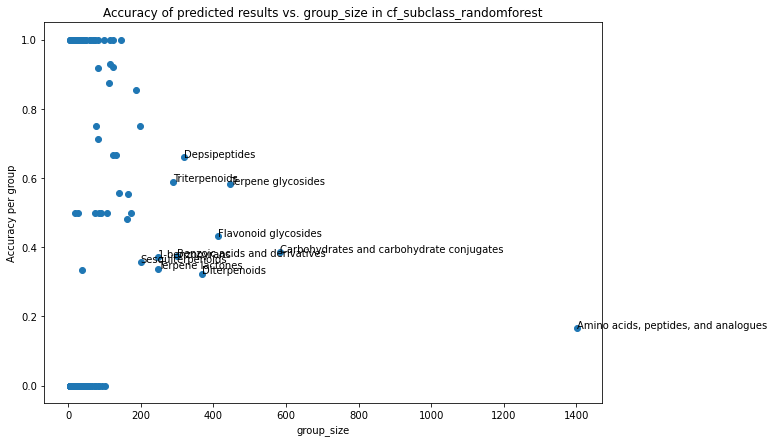

In [7]:
data_type='cf_subclass_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_subclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Class in NPClassifier

(16360,)
309 groups were selected.
(12816,)
(12816, 300)
Processing time: 177.567
Accuracy: 0.313


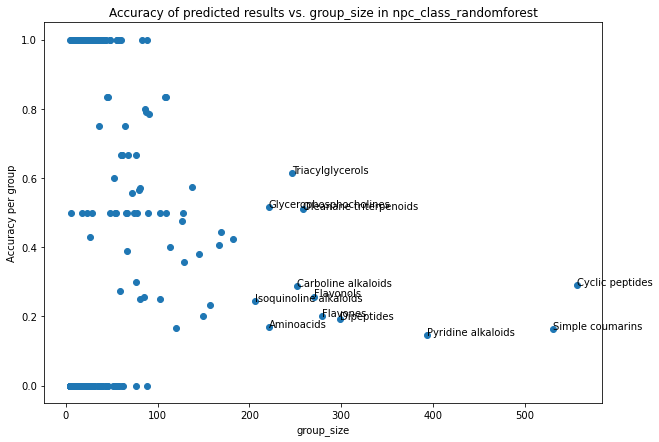

In [8]:
data_type='npc_class_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Superclass in NPClassifier

(16360,)
64 groups were selected.
(13491,)
(13491, 300)
Processing time: 50.183
Accuracy: 0.422


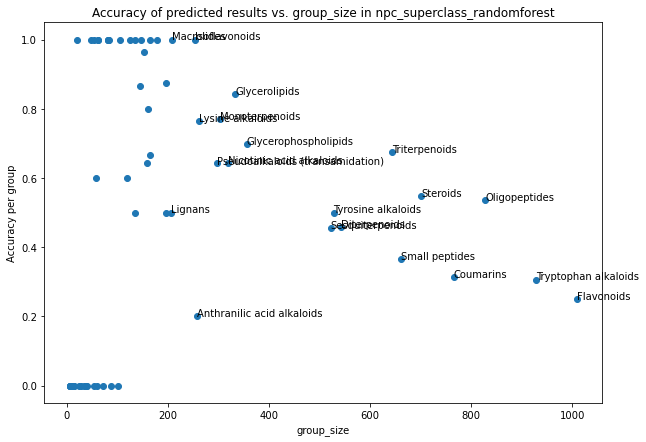

In [9]:
data_type='npc_superclass_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_superclass_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Pathway in NPClassifier

(16360,)
7 groups were selected.
(15268,)
(15268, 300)
Processing time: 23.500
Accuracy: 0.606


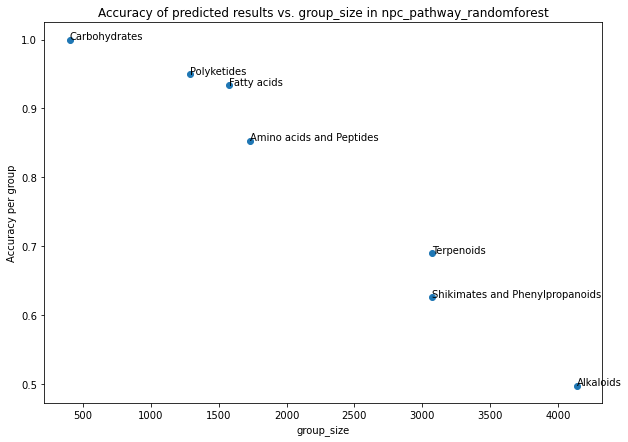

In [10]:
data_type='npc_pathway_randomforest'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_pathway_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

# Redo NPClassifier without multiple-label spectra

In [11]:
# Define the funtion to kick out multiple-label spectra
def kick_out_multilabel_spectra(x_embeddings, y_labels):
    multi_label_index=[]
    for i,v in enumerate(y_labels):
        lbs = v.split(';')
        if len(lbs) >= 2:
            multi_label_index.append(i)
    print(f'{len(multi_label_index)} multiple-label spectra in {len(y_labels)} spectra.')
    new_embeddings = np.delete(x_embeddings,multi_label_index,0)
    print(new_embeddings.shape)
    new_y_labels = [v for i,v in enumerate(y_labels) if i not in multi_label_index]
    print(f'{len(new_y_labels)} spectra left.')
    return new_embeddings, new_y_labels

### Class in NPClassifier

1501 multiple-label spectra in 16360 spectra.
(14859, 300)
14859 spectra left.
295 groups were selected.
(11324,)
(11324, 300)
Processing time: 160.122
Accuracy: 0.315


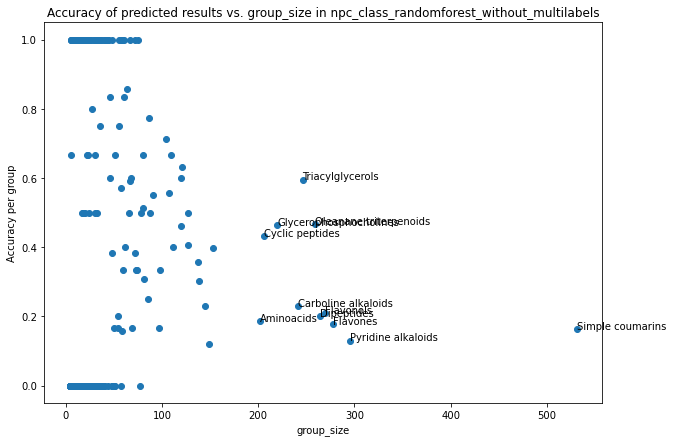

In [12]:
data_type='npc_class_randomforest_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Superclass in NPClassifier

468 multiple-label spectra in 16360 spectra.
(15892, 300)
15892 spectra left.
64 groups were selected.
(13024,)
(13024, 300)
Processing time: 47.162
Accuracy: 0.426


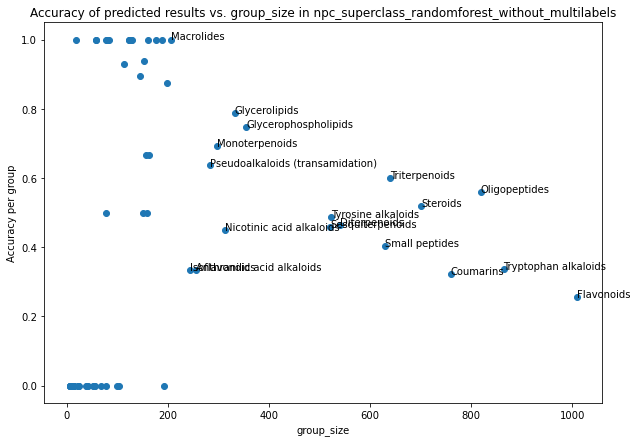

In [13]:
data_type='npc_superclass_randomforest_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_superclass_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Pathway in NPClassifier

895 multiple-label spectra in 16360 spectra.
(15465, 300)
15465 spectra left.
7 groups were selected.
(14373,)
(14373, 300)
Processing time: 21.884
Accuracy: 0.610


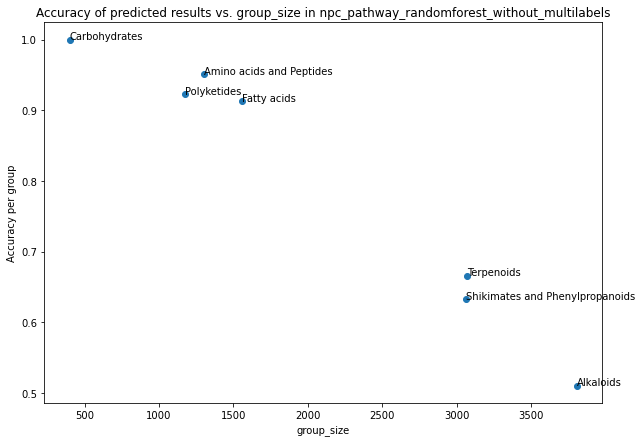

In [14]:
data_type='npc_pathway_randomforest_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_pathway_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_randomforest(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')